
# **Propagación de redes**


**TAREA:**

## **Introducción propagación de redes en bioinformática**

La propagación de redes es una técnica computacional clave en el análisis de estructuras de redes, particularmente en el ámbito de las ciencias biológicas. Su objetivo principal es difundir información o "señales" a través de una red, donde los nodos representan elementos como genes o proteínas, y los bordes reflejan sus relaciones, como interacciones o correlaciones. Este proceso amplifica señales débiles al distribuir datos desde un subconjunto inicial de nodos, permitiendo la identificación de patrones y relaciones que no son evidentes a partir de las interacciones directas. Los algoritmos de propagación de redes, como Random Walk with Restart (RWR) y Heat Diffusion (HD), utilizan la actualización iterativa de valores en los nodos en función de sus vecinos, logrando un equilibrio entre influencias locales y globales.

En este trabajo se hará uso de las herramientas


*   **DIAMOnD** (Disease Module Detection)
*   **GUILD** (Genes Underlying Inheritance Linked Disorders)





## **Dataset**

Se cargan los datos dados por el profesor como el archivo `network_guild.txt` que contiene datos de ID de Entrez. Estos identificadores son utilizados en la base de datos de Entrez Gene, que es un recurso del National Center for Biotechnology Information (NCBI). Cada ID corresponde a un gen específico.

Se catalogan en pares representando la relación entre 2 pares de genes.





### **Carga de datos**

En este apatado se permitirá subir un archivo txt que tenga los genes a estudiar, puede subir un archivo similar al ejemplo `network_diamond.txt`

In [1]:
from google.colab import files
import pandas as pd
import warnings

def upload_file(save_as='Dataset.txt'):
    uploaded = files.upload()
    for filename in uploaded.keys():
        with open(save_as, 'wb') as f:
            f.write(uploaded[filename])
    print(f"Archivo cargado y guardado como '{save_as}' con éxito.")


def read_dataset(sep, expected_cols):
    """Lee el archivo de texto según el separador y verifica el número de columnas."""
    try:
        df = pd.read_csv('Dataset.txt', sep=sep, header=None, engine='python')
        if df.shape[1] == expected_cols:
            return df
    except pd.errors.ParserError as e:
        warnings.warn(f"Error al analizar el archivo: {e}")
    return None

#--------------------------------- FUNCIONES-------------------------------
upload_file()

tipo_dato = None
df = None

# Intentar leer el archivo en varios formatos
for sep, expected_cols, tipo in [(',', 2, "DIAMOND"),
                                 #('\s+', 2, "GO"),
                                 (' 1 ', 2, "GUILD")]:
    df = read_dataset(sep, expected_cols)
    if df is not None:
        tipo_dato = tipo
        break  # Salir del bucle si se encontró un formato válido

# Comprobar el tipo de dato
if tipo_dato is None:
    warnings.warn("El archivo cargado no está preparado para este formato de texto.")

# Asignar nombres a las columnas
df.columns = ['GEN1', 'GEN2']

print(f"Tipo de dato: {tipo_dato}")

# Mostrar la primera fila del DataFrame
print("Primera fila del DataFrame:")
print(df.head(1))



Saving network_diamond.txt to network_diamond.txt
Archivo cargado y guardado como 'Dataset.txt' con éxito.
Tipo de dato: DIAMOND
Primera fila del DataFrame:
   GEN1   GEN2
0  4074  10226



### Información rentrez

En caso de que se diera una lista de ID de genes será interesante estudiar alguno, y tener la posibilidad de analizar cualquier gen en caso de ser necesario.

In [16]:
# Carga de librerías usadas en este proyecto
try:
    from Bio import Entrez
except ModuleNotFoundError:
    # Si no está instalado Biopython, se instala automáticamente
    !pip install biopython
    from Bio import Entrez
import pandas as pd

# Configura tu correo electrónico (y clave de NCBI si la tienes)
Entrez.email = "tu_email@example.com"  # Reemplaza esto con tu correo
# Entrez.api_key = "tu_api_key"  # Descomenta si tienes una clave

def fetch_gene_info(gene_id):
    """Obtiene información de un gen desde NCBI a partir de un solo ID."""
    ids_str = str(gene_id)  # Convierte el ID a cadena

    try:
        # Buscar el ID en la base de datos Gene
        handle = Entrez.efetch(db="gene", id=ids_str, retmode="xml")
        records = Entrez.read(handle)
        handle.close()
    except Exception as e:
        print(f"Error al acceder a la información del gen: {e}")
        return None

    # Extraer la información relevante si está disponible
    gene_info = {}

    try:
        # El nombre del gen puede estar en la clave 'Gene-ref_locus'
        gene_info['Nombre del gen'] = records[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_locus']
    except KeyError:
        gene_info['Nombre del gen'] = "No disponible"

    try:
        # La descripción del gen puede estar en 'Gene-ref_desc'
        gene_info['Descripción del gen'] = records[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_desc']
    except KeyError:
        gene_info['Descripción del gen'] = "No disponible"

    try:
        # El resumen del gen puede estar en 'Entrezgene_summary'
        gene_info['Resumen del gen'] = records[0]['Entrezgene_summary']
    except KeyError:
        gene_info['Resumen del gen'] = "No disponible"
    return gene_info

###################FUNCIONES########################

# Obtener un solo ID de la columna 'GEN1' (por ejemplo, el primer valor)
gene_id = df['GEN1'][0]

# Obtener información del gen
gene_info = fetch_gene_info(gene_id)

# Mostrar la información obtenida
print("Información del primer gen de los datos:")
for key, value in gene_info.items():
    print(f"{key}: {value}")


Información del primer gen de los datos:
Nombre del gen: M6PR
Descripción del gen: mannose-6-phosphate receptor, cation dependent
Resumen del gen: This gene encodes a member of the P-type lectin family. P-type lectins play a critical role in lysosome function through the specific transport of mannose-6-phosphate-containing acid hydrolases from the Golgi complex to lysosomes. The encoded protein functions as a homodimer and requires divalent cations for ligand binding. Alternatively spliced transcript variants encoding multiple isoforms have been observed for this gene. A pseudogene of this gene is located on the long arm of chromosome X. [provided by RefSeq, May 2011]


Para facilitar el entendimiento y comprensión del análisis ópte por crear un código que cambie el dataframe de identificador por sus nombres, el código estará hecho para poder compilar con un dataframe con los IDs o con los nombres de los genes.

### **Advertencia:** No compilar este código si no quieres hacer un análisis profundo, en el caso de un txt con  más de 1840 genes únicos como es el caso de network_diamond.txt,  sabiendo que consultar el nombre de cada gen toma 1 segundo de coldown, el proceso puede tomar más de 30 minutos

In [31]:
from Bio import Entrez
import pandas as pd
import time

# Función para obtener el nombre del gen desde el ID de Entrez
def get_gene_name(entrez_id):
    """Obtiene información de un gen desde NCBI a partir de un solo ID."""
    ids_str = str(entrez_id)  # Convierte el ID a cadena
    try:
        # Buscar el ID en la base de datos Gene
        handle = Entrez.efetch(db="gene", id=ids_str, retmode="xml")
        records = Entrez.read(handle)
        handle.close()
    except Exception as e:
        print(f"Error al acceder a la información del gen: {e}")
        return None

    try:
        # El nombre del gen puede estar en la clave 'Gene-ref_locus'
        nombre = records[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_locus']
        return nombre
    except KeyError:
        nombre = "No disponible"
        return nombre  # Añadido para asegurarse de que se retorna algo

#########################uso################################
# Ejemplo de DataFrame con interacciones de genes
df_interactions = df.copy()  # Asegúrate de que este es tu DataFrame original


# Obtener todos los identificadores únicos de genes
unique_genes = pd.concat([df_interactions['GEN1'], df_interactions['GEN2']]).unique()
unique_genes = [str(gene) for gene in unique_genes]  # Convertir a cadena

# Crear un diccionario para almacenar los nombres de los genes
gene_name_mapping = {}

# Llenar el diccionario con los nombres de genes
for entrez_id in unique_genes:
    gene_name = get_gene_name(entrez_id)
    gene_name_mapping[entrez_id] = gene_name
    time.sleep(1)  # Respetar la tasa de consultas a NCBI


# Asegúrate de que los identificadores en df_interactions sean cadenas
df_interactions['GEN1'] = df_interactions['GEN1'].astype(str)
df_interactions['GEN2'] = df_interactions['GEN2'].astype(str)

# Reemplazar identificadores en el DataFrame original con los nombres de genes
df_interactions['GEN1_name'] = df_interactions['GEN1'].map(gene_name_mapping)
df_interactions['GEN2_name'] = df_interactions['GEN2'].map(gene_name_mapping)

print(df_interactions)


Error al acceder a la información del gen: HTTP Error 400: Bad Request
Error al acceder a la información del gen: HTTP Error 400: Bad Request
Error al acceder a la información del gen: HTTP Error 400: Bad Request
       GEN1    GEN2 GEN1_name  GEN2_name
0      4074   10226      M6PR      PLIN3
1      2288  140735     FKBP4     DYNLL2
2      2288   10671     FKBP4      DCTN6
3      2288   93661     FKBP4     CAPZA3
4      2288    5481     FKBP4       PPID
...     ...     ...       ...        ...
13673  4586   29071    MUC5AC  C1GALT1C1
13674  4586    7031    MUC5AC       TFF1
13675  4586   56667    MUC5AC      MUC13
13676  4586  140687    MUC5AC      GCNT7
13677  4586   11227    MUC5AC     GALNT5

[13678 rows x 4 columns]


### **DIAMOnD**

se centra en la identificación de módulos de enfermedades dentro de redes de interacción proteína-proteína. Su metodología agrega nodos a conjuntos de genes de enfermedades conocidos en función de su proximidad topológica, construyendo módulos coherentes que probablemente estén involucrados en procesos biológicos relacionados. Aunque DIAMOnD destaca en la priorización de genes asociados a enfermedades, su efectividad puede verse limitada al considerar grandes volúmenes de genes candidatos. En conjunto, tanto GUILD como DIAMOnD ilustran la aplicabilidad de la propagación de redes en el análisis de complejas interacciones biológicas.

Esto será un código modificado del repositorio: https://github.com/dinaghiassian/DIAMOnD.

[Susan Dina Ghiassian](https://https://github.com/dinaghiassian) es la autora intelectual de este algoritmo.


#### **Preparación de datos**
Para aplicar DIAMOnD se necesitará los siguientes puntos definidos previamente:
1.    **network_file** (archivo de red): Este archivo contiene una lista de interacciones entre genes (o nodos de una red). Se espera que esté en formato de lista de aristas (edgelist), donde cada fila tiene dos columnas que representan una interacción entre dos genes (gene1 y gene2).

2.    **seed_file** (archivo de genes semilla): Este archivo contiene una lista de genes "semilla", que son los genes iniciales alrededor de los cuales se expandirá la red utilizando DIAMOnD. (para este trabajo se tomó la libertad para implementar un código capaz de crear un seed_file automáticamente basandose en network_file)

3.   **n** (número de genes DIAMOnD): Este parámetro especifica cuántos genes adicionales se deben agregar a los genes semilla en el proceso de expansión de la red. Un valor común para este parámetro es 200.

4.  **alpha** (peso de las semillas, opcional): Es un número entero que indica la importancia o el "peso" que se da a los genes semilla en el algoritmo. El valor predeterminado es 1, lo que significa que se les da un peso normal.



In [47]:
# Leer la lista de adyacencia desde un DataFrame
import networkx as nx

#funcion que crea el grafo a partir del dataframe estudiado
def read_input_from_df(df):
    G = nx.Graph()

    # Recorre el DataFrame fila por fila, agregando cada arista al grafo
    for index, row in df.iterrows():
        node1 = str(row.iloc[0])  # Acceder a la primera columna por posición
        node2 = str(row.iloc[1])  # Acceder a la segunda columna por posición
        G.add_edge(node1, node2)

    return G

################################### main##############################

# Leer el grafo desde el DataFrame
df_name = df_interactions[['GEN1_name', 'GEN2_name']]
G = read_input_from_df(df_name)

# Parámetros
n = 200
alpha = 1


#### Selección de genes semilla en DIAMOnD

Para seleccionar los genes semilla en DIAMOnD, se pueden tomar multiples enfoques, en este caso se evaluarán 3:



1.   **Selección basada en grado:** Elige los nodos con mayor número de conexiones. *Ventaja:* asegura que se seleccionen nodos clave en la red. *Desventaja:* puede sobrevalorar nodos muy conectados pero no necesariamente relevantes.




In [48]:
gen1_total = df['GEN1'].nunique()
num_seeds = int(gen1_total * 0.15)
print(f"Número de genes semillas automatizado: {num_seeds}, al ser el 15% de los genes totales")

Número de genes semillas automatizado: 276, al ser el 15% de los genes totales


In [49]:
def select_seed_genes_by_degree(G, num_seeds=15):
    # Ordenar nodos por su grado (de mayor a menor)
    sorted_nodes_by_degree = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)
    # Seleccionar los primeros 'num_seeds' nodos
    seed_genes = set(sorted_nodes_by_degree[:num_seeds])
    return seed_genes

# Ejemplo de uso:
seed_genes_grado = select_seed_genes_by_degree(G, num_seeds)



2.   **Selección basada en centralidad:** Utiliza la centralidad de intermediación para identificar nodos que actúan como "puentes" entre diferentes módulos. *Ventaja:* detecta genes clave en la regulación de distintos procesos. *Desventaja:* puede omitir genes importantes dentro de módulos específicos.



In [50]:
def select_seed_genes_by_centrality(G, num_seeds):
    centrality = nx.betweenness_centrality(G)  # Calcula la centralidad de intermediación
    # Ordenar los nodos por centralidad de mayor a menor
    sorted_nodes_by_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    # Seleccionar los primeros 'num_seeds' nodos
    seed_genes = set([node for node, centrality_value in sorted_nodes_by_centrality[:num_seeds]])
    return seed_genes

# Ejemplo de uso:
seed_genes_central = select_seed_genes_by_centrality(G, num_seeds)


3.   **Selección aleatoria:** Escoge nodos sin un criterio previo. *Ventaja:* evita sesgos y es simple de implementar. *Desventaja:* puede incluir genes menos relevantes o periféricos.



In [51]:
import random

def select_seed_genes_random(G, num_seeds):
    """Selecciona genes de semilla aleatoriamente de la red."""
    nodes = list(G.nodes())
    seed_genes = set(random.sample(nodes, num_seeds))
    return seed_genes

# Ejemplo de uso
seed_genes_random = select_seed_genes_random(G, num_seeds)


Además de estas opciones, esta la posibilidad de implementarlo manualmente, esto podría dar mejores resultados al evaluar la importancia biólogica de los genes, pero conllevaría un mayor trabajo.

Aplicamos DIAMOnD en el dataset dado, obteniendo la siguiente gráfica:


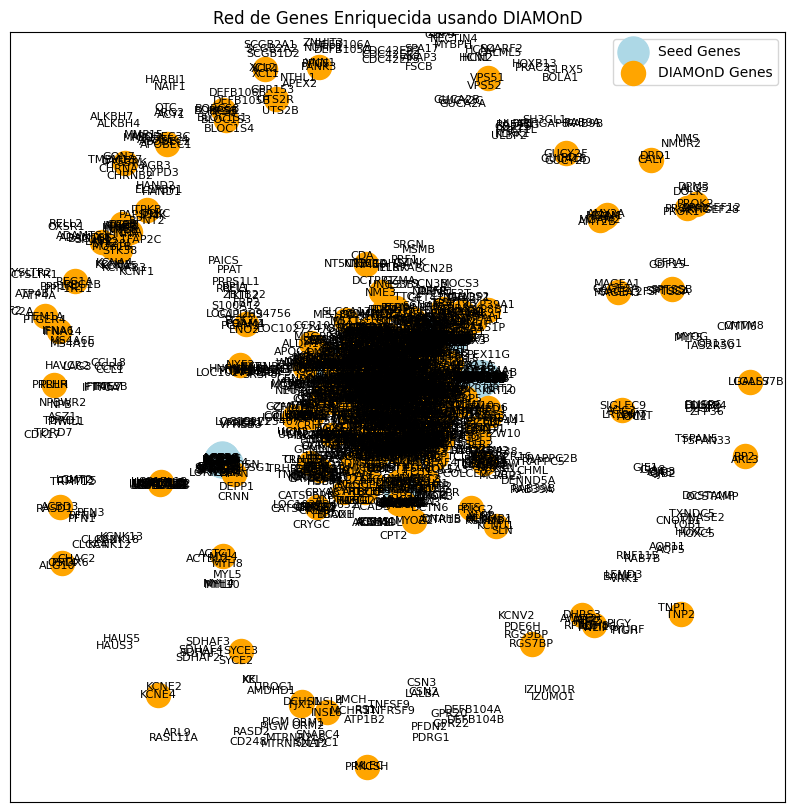

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from collections import defaultdict

# ------------------- FUNCIONES DE DIAMOND -------------------
def compute_all_gamma_ln(N):
    gamma_ln = {i: scipy.special.gammaln(i) for i in range(1, N + 1)}
    return gamma_ln

def gauss_hypergeom(x, r, b, n, gamma_ln):
    max_index = len(gamma_ln) - 1  # El último índice permitido
    if r + b > max_index or x > max_index or r < x or b < (n - x):
        # Si los índices están fuera de rango, manejar el error
        return 0  # Un p-valor predeterminado, puedes cambiarlo a 1 si es necesario

    return np.exp(gamma_ln[r] - (gamma_ln[x] + gamma_ln[r - x]) +
                  gamma_ln[b] - (gamma_ln[n - x] + gamma_ln[b - n]) -
                  gamma_ln[r + b])

def pvalue(kb, k, N, s, gamma_ln):
    return sum(gauss_hypergeom(n, s, N - s, k, gamma_ln) for n in range(kb, k + 1))

def diamond_iteration_of_first_X_nodes(G, S, X, alpha=1):
    added_nodes = []
    neighbors = {node: set(G.neighbors(node)) for node in G.nodes}
    degrees = {node: G.degree(node) for node in G.nodes}
    cluster_nodes = set(S)
    gamma_ln = compute_all_gamma_ln(len(G.nodes))  # Precomputar gamma_ln para el número total de nodos

    while len(added_nodes) < X:
        min_p = float('inf')
        next_node = None
        for node in set(G.nodes) - cluster_nodes:
            k = degrees[node]  # Grado total del nodo
            kb = sum((1 for neighbor in neighbors[node] if neighbor in cluster_nodes))  # Grado en semillas
            # Debug: imprimir valores
            #print(f"Node: {node}, k: {k}, kb: {kb}, Cluster Size: {len(cluster_nodes)}")
            try:
                p = pvalue(kb, k, len(G.nodes), len(cluster_nodes), gamma_ln)
            except ValueError as e:
                print(f"Error calculando pvalue para nodo {node}: {e}")
                continue  # Salir del ciclo si hay error

            if p < min_p:
                min_p = p
                next_node = node

        if next_node:
            added_nodes.append(next_node)
            cluster_nodes.add(next_node)
    return added_nodes

# ------------------- VISUALIZACIÓN -------------------
def graficar_red_enriquecida(G, seed_genes, diamond_genes):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 10))

    # Nodos de semillas
    nx.draw_networkx_nodes(G, pos, nodelist=seed_genes, node_color='lightblue', node_size=500, label="Seed Genes")

    # Nodos DIAMOnD
    nx.draw_networkx_nodes(G, pos, nodelist=diamond_genes, node_color='orange', node_size=300, label="DIAMOnD Genes")

    # Enlaces
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in G.edges() if u in (seed_genes | set(diamond_genes)) and v in (seed_genes | set(diamond_genes))], alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.legend(loc="best")
    plt.title("Red de Genes Enriquecida usando DIAMOnD")
    plt.show()

# ------------------- EJECUCIÓN -------------------
#tienes que tener los datos cargados, mira el código del chunk superior

seed_genes= seed_genes_grado #ejemplo usando grado

diamond_genes = diamond_iteration_of_first_X_nodes(G, seed_genes, n, alpha)

# Graficar red enriquecida
graficar_red_enriquecida(G, seed_genes, diamond_genes)


El código anterior fue usando un método de selección de semilla basada en grado, a continuación se llamará a la función usando `seed_genes_central`, correspondiente a las semillas obtenidas de una selección basada en centralidad

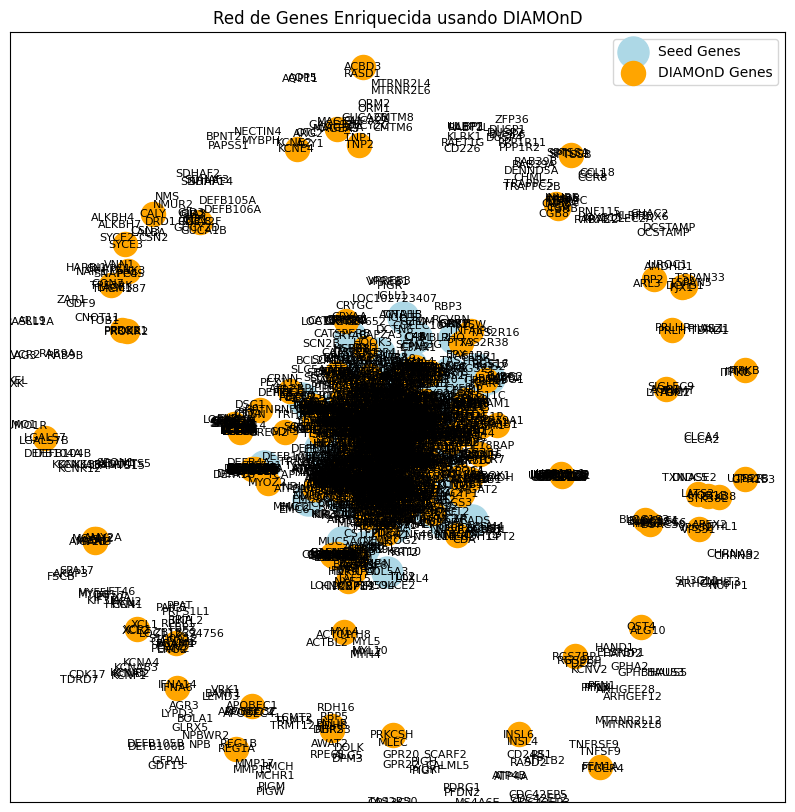

In [53]:
# ------------------- EJECUCIÓN -------------------
#tienes que tener los datos cargados, mira el código del chunk superior

seed_genes= seed_genes_central #ejemplo usando grado

diamond_genes = diamond_iteration_of_first_X_nodes(G, seed_genes, n, alpha)

# Graficar red enriquecida
graficar_red_enriquecida(G, seed_genes, diamond_genes)

Por ultimo se muestra como se vería con la selección de semillas aleatorias, viendo que no son buenos resutados

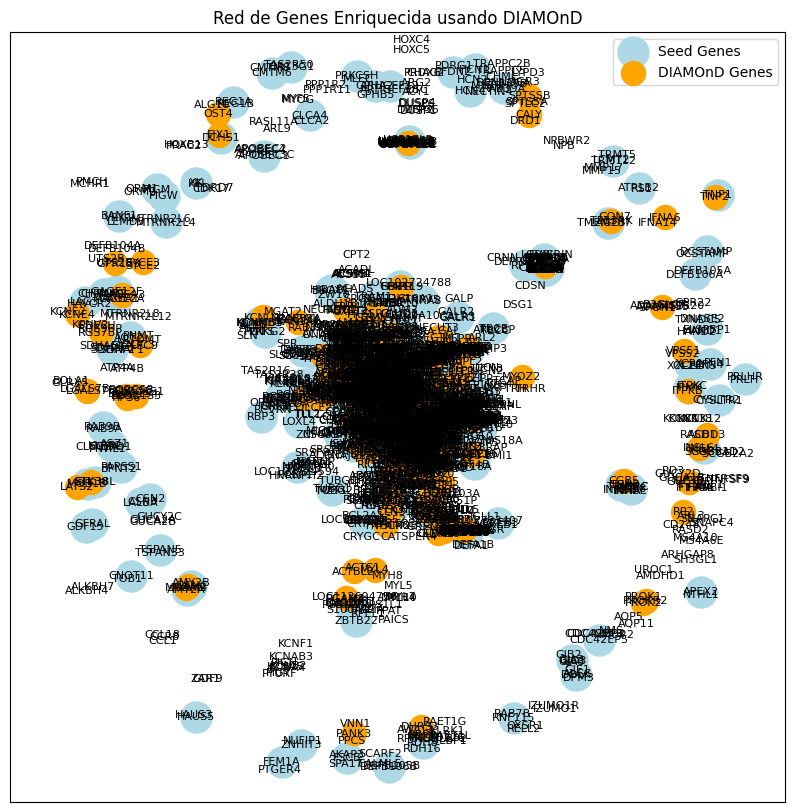

In [54]:
# ------------------- EJECUCIÓN -------------------
#tienes que tener los datos cargados, mira el código del chunk superior

seed_genes= seed_genes_random #ejemplo usando grado

diamond_genes = diamond_iteration_of_first_X_nodes(G, seed_genes, n, alpha)

# Graficar red enriquecida
graficar_red_enriquecida(G, seed_genes, diamond_genes)

Viendo los 3 métodos, se puede ver que destaca positivamente la Selección basada en centralidad para las semillas

##  **GUILD**
Es un marco integral que prioriza genes según su relevancia para enfermedades específicas. Integra múltiples métodos de propagación de red, como NetScore y NetZcore, para clasificar nodos en función de su conexión y su importancia biológica. NetScore, por ejemplo, utiliza un enfoque de paso de mensajes donde las puntuaciones se actualizan de manera iterativa, mientras que NetZcore normaliza estas puntuaciones a través de redes aleatorias, reduciendo el sesgo hacia nodos altamente conectados. Esta versatilidad permite que GUILD sea aplicado en diversas redes, facilitando descubrimientos en dianas farmacológicas y priorización de genes.



Lineas descartadas:
Otra idea que tuve fue

Utilizar la herramienta AmiGO (Gene Ontology), que permite buscar información sobre genes y productos génicos en relación con términos de la ontología de procesos biológicos. Busqué específicamente el término **GO:0006119 (oxidative phosphorylation)**, que hace referencia a la fosforilación oxidativa.

Apliqué los siguientes filtros:

*   **Taxon subset closure label: Homo sapiens**, para limitar la búsqueda a humanos.
*   **isa_partof_closure: GO:0006119**, para asegurarme de que los resultados estén relacionados específicamente con la fosforilación oxidativa.

